# 三种双线性插值算法的时间复杂度比较

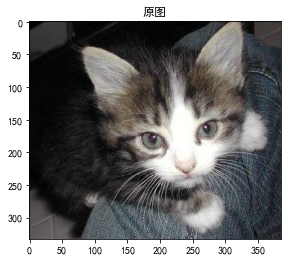

In [282]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False 
%matplotlib inline
img = plt.imread('D:\kkb\cartrace\cat.png')
plt.imshow(img)
plt.title("原图")
plt.show()

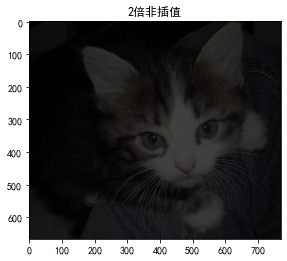

In [283]:
def unpooling(src, scale):
  assert isinstance(scale, int)
  src_h, src_w, channel = src.shape
  dst_h = src_h * scale
  dst_w = src_w * scale
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  dst[::scale, ::scale] = src
  return dst

img_u = unpooling(img, 2)
plt.imshow(img_u)
plt.title("2倍非插值")
plt.show()

## 三重循环实现（三维空间的遍历）

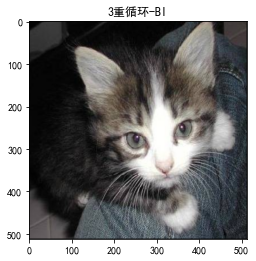

In [284]:
def bilinear_interpolation(src, dst_size):
  src_h, src_w, channel = src.shape
  dst_w, dst_h = dst_size
  x_scale = dst_w / src_w
  y_scale = dst_h / src_h
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  for c in range(channel):
    for dst_x in range(dst_w):
        
          for dst_y in range(dst_h):
            src_x = (dst_x + 0.5) / x_scale - 0.5
            src_y = (dst_y + 0.5) / y_scale - 0.5

            src_x1 = int(src_x)
            src_y1 = int(src_y)
            src_x2 = src_x1 + 1
            src_y2 = src_y1 + 1

            def clip(v, vmin, vmax):
              v = v if v >= vmin else vmin
              v = v if v <= vmax else vmax
              return v

            src_x1 = clip(src_x1, 0, src_w-1)
            src_x2 = clip(src_x2, 0, src_w-1)
            src_y1 = clip(src_y1, 0, src_h-1)
            src_y2 = clip(src_y2, 0, src_h-1)

            y1_value = (src_x - src_x1) * src[src_y1, src_x2, c] + (src_x2 - src_x) * src[src_y1, src_x1, c]
            y2_value = (src_x - src_x1) * src[src_y2, src_x2, c] + (src_x2 - src_x) * src[src_y2, src_x1, c]
            dst[dst_y, dst_x, c] = (src_y - src_y1) * y2_value + (src_y2 - src_y) * y1_value
  return dst

img_a = bilinear_interpolation(img, (512, 512))
plt.imshow(img_a)
plt.title("3重循环-BI")
plt.show()

## 二重循环实现（二维平面的遍历）

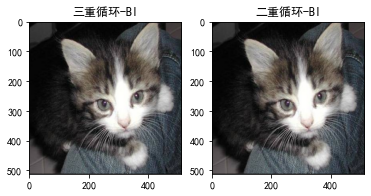

In [285]:
def bilinear_interpolation_v1(src, dst_size):
  src_h, src_w, channel = src.shape
  dst_w, dst_h = dst_size
  x_scale = dst_w / src_w
  y_scale = dst_h / src_h
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  for dst_x in range(dst_w):
      for dst_y in range(dst_h):
        src_x = (dst_x + 0.5) / x_scale - 0.5
        src_y = (dst_y + 0.5) / y_scale - 0.5

        src_x1 = int(src_x)
        src_y1 = int(src_y)
        src_x2 = src_x1 + 1
        src_y2 = src_y1 + 1

        def clip(v, vmin, vmax):
          v = v if v >= vmin else vmin
          v = v if v <= vmax else vmax
          return v

        src_x1 = clip(src_x1, 0, src_w-1)
        src_x2 = clip(src_x2, 0, src_w-1)
        src_y1 = clip(src_y1, 0, src_h-1)
        src_y2 = clip(src_y2, 0, src_h-1)

        y1_value = (src_x - src_x1) * src[src_y1, src_x2] + (src_x2 - src_x) * src[src_y1, src_x1]
        y2_value = (src_x - src_x1) * src[src_y2, src_x2] + (src_x2 - src_x) * src[src_y2, src_x1]
        dst[dst_y, dst_x] = (src_y - src_y1) * y2_value + (src_y2 - src_y) * y1_value
  return dst

img_b = bilinear_interpolation_v1(img, (512, 512))
plt.subplot(121)
plt.imshow(img_a)
plt.title("三重循环-BI")
plt.subplot(122)
plt.imshow(img_b)
plt.title("二重循环-BI")
plt.show()

## 基于Tensor的思想实现

用Tensor的思想实现双线性插值算法：<br><br/>
1.用坐标索引的方式表示扩大后的坐标在源图上坐标的映射（np.mgrid函数用网格表示坐标）；<br><br/>
2.得到双线性插值所需要的源图中的四个坐标；<br><br/>
3.利用双线性公式进行插值计算<br><br/>
⭐此处是将四个坐标分别放在四个三维空间中，因为src[src_y1, src_x2]表示为1个(512,512,3)的tensor，但是计算的公式不变<br><br/>

(512, 512)


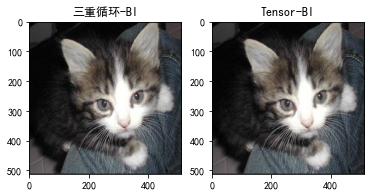

In [286]:
def bilinear_interpolation_v2(src, dst_size):
    
    src_h, src_w, channel = src.shape
    dst_w, dst_h = dst_size
    x_scale = dst_w / src_w
    y_scale = dst_h / src_h
    dst_y, dst_x = np.mgrid[:dst_h, :dst_w]
    #定义(512,512,3)存最后的输出结果
    dst=np.zeros([dst_w, dst_h,3])
    #将目标图的坐标映射到源图
    src_x = (dst_x + 0.5) / x_scale - 0.5
    src_y = (dst_y + 0.5) / y_scale - 0.5
    
    
    #找出源图中计算（x,y）周围的四个点的坐标
    src_x1 = src_x.astype(np.int64)
    src_y1 = src_y.astype(np.int64)
    src_x2 = src_x1 + 1
    src_y2 = src_y1 + 1
    print(src_y2 .shape)
    
    #生成4个3维空间（也即(x,y)的周围四个点分别在三个四个空间中）
    
    src_x1 = np.clip(src_x1, 0, src_w-1)
    src_x2 = np.clip(src_x2, 0, src_w-1)
    src_y1 = np.clip(src_y1, 0, src_h-1)
    src_y2 = np.clip(src_y2, 0, src_h-1)
    
    #src[src_y1, src_x2]记为一个空间
    for i in range(3):
        y1_value = (src_x - src_x1) * src[src_y1, src_x2][:,:,i] + (src_x2 - src_x) * src[src_y1, src_x1][:,:,i]
        y2_value = (src_x - src_x1) * src[src_y2, src_x2][:,:,i] + (src_x2 - src_x) * src[src_y2, src_x1][:,:,i]
        dst[:,:,i] = (src_y - src_y1) * y2_value + (src_y2 - src_y) * y1_value
    
        
    return dst

img_c = bilinear_interpolation_v2(img, (512, 512))
plt.subplot(121)
plt.imshow(img_a)
plt.title("三重循环-BI")
plt.subplot(122)
plt.imshow(img_c)
plt.title("Tensor-BI")
plt.show()

## 时间复杂度比较

In [287]:
import time
t1 = time.time()
img_n0 = bilinear_interpolation(img, (512, 512))
t2 = time.time()
img_n1 =bilinear_interpolation_v1(img, (512, 512))
t3 = time.time()
img_n2 = bilinear_interpolation_v2(img, (512, 512))
t4 = time.time()
print('Difference 0-1: ', ((img_n0- img_n1)**2).sum())
print('Difference 0-2: ', ((img_n0 - img_n2)**2).sum())
print('Difference 1-2: ', ((img_n1 - img_n2)**2).sum())
print('v0: %.6f' % (t2 - t1),"秒")
print('v1: %.6f' % (t3 - t2),"秒")
print('v2: %.6f' % (t4 - t3),"秒")

(512, 512)
Difference 0-1:  2.7627584e-10
Difference 0-2:  6.678582458116217e-11
Difference 1-2:  2.1342451776927687e-10
v0: 12.110739 秒
v1: 3.661247 秒
v2: 0.184778 秒


## 结果分析

1.误差分析：三种算法的误差非常小，在0-255的幅值下，且分辨率为512x512x3的情况下，平均每点的像素差别完全可以忽略不计；<br><br/>
2.时间复杂度：可看出，3重循环的时间复杂度差不多是2重循环的3倍，符合客观；<br><br/>利用Tensor的算法时间复杂度是3重循环的1/64，体现了矩阵运算的优越性